In [701]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from io import StringIO
import time

In [643]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [711]:
# get API key
with open('api2.txt', 'r') as file:
    apikey = file.read()

In [656]:
# Wikipedia API URL to fetch the page content
URL = "https://en.wikipedia.org/wiki/Academy_Award_for_Best_Picture"

# Get the page HTML
response = requests.get(URL)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all tables on the page
tables = soup.find_all("table", {"class": "wikitable"})

In [657]:
movies = []

# Track the most recent year found
current_year = None  

# Iterate through tables
for table in tables:
    # Convert table to DataFrame
    try:
        df = pd.read_html(StringIO(str(table)))[0]
    except:
        continue  # Skip tables that can't be read

    # Check if "Film" is in the column names
    if "Film" not in df.columns:
        continue  # Skip tables without the correct format

    # Process each row in the table
    for row in table.find_all("tr"):
        cols = row.find_all(["th", "td"])  # Extract headers and data cells

        # Check if this row contains the year
        if cols[0].name == "th":  
            current_year = cols[0].text.strip()  # Update the stored year
            cols = cols[1:]  # Remove the year cell from further processing

        if not current_year:
            continue  # Skip rows until a year is found

        # Check if this row has the yellow background (winner)
        is_winner = 'background:#FAEB86' in row.get('style', '')

        # Extract only the FIRST `<a>` tag, which is the movie name
        for col in cols:  
            movie_link = col.find("a")  # Get the first link (movie name)
            if not movie_link:
                continue
            
            movie_name = movie_link.text.strip()
            movie_url = "https://en.wikipedia.org" + movie_link["href"]  # Full Wikipedia link

            # Append to the results
            movies.append((current_year, movie_name, movie_url, is_winner))
            break  # Stop after getting the first `<a>` (ignores producer links)

# Convert to DataFrame
movies_df = pd.DataFrame(movies, columns=["Year", "Movie", "Wikipedia Link", "Winner"])

In [658]:
# clean the years - note: 1933 is missing??
movies_df.loc[0:2, 'Year'] = 1927
movies_df.loc[3:7, 'Year'] = 1928
movies_df.loc[8:12, 'Year'] = 1929
movies_df.loc[13:17, 'Year'] = 1930
movies_df.loc[18:25, 'Year'] = 1931
movies_df.loc[26:35, 'Year'] = 1932

for i in range(36, len(movies_df)):
    value = movies_df['Year'].iloc[i]  # Get the value of the 'YearString' column at the current index

    # Use regex to extract the year (first 4 digits)
    match = re.search(r'\b(\d{4})\b', value)
    
    # If a match is found, directly update the 'Year' column with the extracted year
    if match:
        movies_df.at[i, 'Year'] = match.group(1)
    else:
        movies_df.at[i, 'Year'] = None

In [ ]:
# remove disorganized years (36 total)
movies_df = movies_df[~movies_df['Year'].isin([1927, 1928, 1929, 1930, 1931, 1932, 1933])]

In [ ]:
distributors2 = []

# get all the distributors
for movie_url in movies_df['Wikipedia Link']:
    response = requests.get(movie_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    distributed_by_row = soup.find('th', string='Distributed by')

    if distributed_by_row:
        td_element = distributed_by_row.find_next('td')

        # Check if there is an anchor tag inside the <td>
        a_tag = td_element.find('a')
        if a_tag:
            dist_company = a_tag.get_text(strip=True)  # Get text from <a> tag
        else:
            dist_company = td_element.get_text(strip=True)  # Get text directly from <td>
    else:
        dist_company = 'N/A'

    distributors2.append(dist_company)


In [664]:
# clean the distributors list
def remove_bracketed_numbers(input_list):
    # Remove any text within square brackets, including the brackets
    cleaned_list = [re.sub(r'\[\d+\]', '', item).strip() for item in input_list]
    
    # Replace empty strings with "N/A"
    cleaned_list = ['N/A' if item == '' else item for item in cleaned_list]
    
    return cleaned_list

cleaned_dist = remove_bracketed_numbers(distributors2)

In [665]:
# add to dataframe
movies_df['Distributor'] = cleaned_dist

In [666]:
producers2 = []

# get all the producers
for movie_url in movies_df['Wikipedia Link']:
    response = requests.get(movie_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    produced_by_row = soup.find('th', string='Produced by')

    if produced_by_row:
        td_element = produced_by_row.find_next('td')
        # Check if there are any <a> tags in the <td>
        a_tags = td_element.find_all('a')
        if a_tags:
            # Extract names if there are <a> tags
            producer_names = [a_tag.get_text(strip=True) for a_tag in a_tags]
        else:
            # Otherwise, it's plain text in the <td>
            producer_names = [td_element.get_text(strip=True)]
    else:
        producer_names = "N/A"
    
    producers2.append(producer_names)

In [ ]:
# clean manually - wasn't working any other way...
producers2[561] = ['Martin Scorsese', 'Steven Spielberg', 'Fred Berner', 'Amy Durning', 'Kristie Macosko Krieger']
producers2[556] = ['Nikos Karamigios']
producers2[553] = ['Erik Hemmendorff', 'Philippe Bober']
producers2[545] = ['Joe Russo', 'Anthony Russo', 'Mike Larocca', 'Jonathan Wang']
producers2[536] = ['Laura Berwick', 'Kenneth Branagh', 'Becca Kovacik', 'Tamar Thomas']
producers2[535] = ['Philippe Rousselet', 'Jérôme Seydoux']
producers2[516] = ['Bill Gerber', 'Jon Peters', 'Todd Phillips', 'Lynette Howell Taylor']
producers2[523] = ['Bill Benz', 'Kathy Benz', 'Bert Hamelinck', 'Sacha Ben Harroche']
producers2[436] = ['Joel Coen', 'Ethan Coen']
producers2[365] = 'N/A'
producers2[323] = ['Norman Jewison', 'Patrick Palmer']
producers2[322] = ['John Boorman', 'Michael Dryhurst']
producers2[283] = ['Tamara Asseyev', 'Alexandra Rose']
producers2[236] = ['Bob Rafelson', 'Richard Wechsler']
producers2[217] = ['Charles Maguire']
producers2[126] = ['Michael Powell', 'Emeric Pressburger']
producers2[122] = ['Anthony Havelock-Allan', 'Ronald Neame']
producers2[105] = ['Joseph Sistrom']
producers2[83] = ['Alfred Hitchcock', 'Harry E. Edington']
producers2[58] = ['Frank Capra']
producers2[50] = ['Albert Pinkovitch', 'Frank Rollmer']

In [676]:
# add to dataframe
movies_df['Producer(s)'] = producers2

In [677]:
# clean the producers list
def clean_producers(producer):
    if isinstance(producer, list):
        # If the producer is a list, join the names and clean
        producer = ', '.join(producer)
    
    # Now clean the string (remove square brackets and strip spaces)
    cleaned_producer = re.sub(r'[\[\]]', '', producer).strip()
    
    return cleaned_producer

# Apply the function to the 'Producer(s)' column
movies_df['Producer(s)'] = movies_df['Producer(s)'].apply(clean_producers)


In [729]:
movies_df.reset_index(drop=True, inplace=True) # reset the index so it doesn't start at [36]
movies_df= movies_df.drop('Wikipedia Link', axis=1) # get rid of link column

In [683]:
# identify the years and separate into decades column
movies_df['Year'] = pd.to_numeric(movies_df['Year'], errors='coerce')
bins = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ['1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
movies_df['Decade'] = pd.cut(movies_df['Year'], bins=bins, labels=labels, right=False, include_lowest=True)

In [ ]:
# testing to see if it works just with the title

# runtimes2 = []
# genres2 = []
# writers2 = []
# revenue2 = []
# actors2 = []
# ratings2 = []

# for movie in movies_df['Movie']:

#     parameters = {'apikey': apikey, 
#                   't': movie}
    
#     response = requests.get('http://www.omdbapi.com', params=parameters)
#     movie_info = response.json()

    # length2 = movie_info.get('Runtime', 'N/A')
    # runtimes2.append(length2)

    # genre2 = movie_info.get('Genre', 'N/A')
    # genres2.append(genre2)

    # writer2 = movie_info.get('Writer', 'N/A')
    # writers2.append(writer2)

    # box_office2 = movie_info.get('BoxOffice', 'N/A')
    # revenue2.append(box_office2)

    # actor2 = movie_info.get('Actors', 'N/A')
    # actors2.append(actor2)

    # rating2 = movie_info.get('imdbRating', 'N/A')
    # ratings2.append(rating2)

In [721]:
# get more info

runtimes3 = []
genres3 = []
writers3 = []
revenue3 = []
actors3 = []
ratings3 = []
directors3 = []

for index, movie in movies_df.iterrows():
    
    parameters = {
        'apikey': apikey,
        't': movie['Movie'],  # The movie title
        'y': movie['Year']    # The year of the movie (because two movies could have the same title)
    }
    
    response = requests.get('http://www.omdbapi.com', params=parameters)
    movie_info = response.json()
    
    length3 = movie_info.get('Runtime', 'N/A')
    runtimes3.append(length3)

    genre3 = movie_info.get('Genre', 'N/A')
    genres3.append(genre3)

    writer3 = movie_info.get('Writer', 'N/A')
    writers3.append(writer3)

    box_office3 = movie_info.get('BoxOffice', 'N/A')
    revenue3.append(box_office3)

    actor3 = movie_info.get('Actors', 'N/A')
    actors3.append(actor3)

    rating3 = movie_info.get('imdbRating', 'N/A')
    ratings3.append(rating3)

    director3 = movie_info.get('Director', 'N/A')
    directors3.append(director3)

time.sleep(1)

In [749]:
# add to dataframe
movies_df['Runtime (min)'] = runtimes3
movies_df['Genre'] = genres3
movies_df['Writer(s)'] = writers3
movies_df['BoxOffice'] = revenue3
movies_df['Actors'] = actors3
movies_df['IMDbRating'] = ratings3
movies_df['Director'] = directors3

In [750]:
# rearrange columns
movies_df = movies_df[['Year', 'Decade', 'Winner', 'Movie', 'IMDbRating', 'Runtime', 'Director', 'Actors', 'Writer(s)', 'Distributor', 'Producer(s)', 'Genre', 'BoxOffice']]

In [785]:
# check types
movies_df.dtypes

Year              int64
Decade         category
Winner             bool
Movie            object
IMDbRating      float64
Runtime         float64
Director         object
Actors           object
Writer(s)        object
Distributor      object
Producer(s)      object
Genre            object
BoxOffice       float64
dtype: object

In [751]:
# replace all the N/A with NaN
movies_df.replace('N/A', np.nan, inplace=True)

/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/973084856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df.replace('N/A', np.nan, inplace=True)


In [760]:
# remove all the minutes phrase and convert to float type
#movies_df['Runtime'] = movies_df['Runtime'].str.replace(' min', '').str.strip()
#movies_df['Runtime'] = pd.to_numeric(movies_df['Runtime'], errors='coerce')

In [783]:
movies_df['BoxOffice'] = movies_df['BoxOffice'].replace({'\$': '', ',': ''}, regex=True)
movies_df['BoxOffice'] = movies_df['BoxOffice'].astype(float)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/3050680495.py:1: SyntaxWarning: invalid escape sequence '\$'
  movies_df['BoxOffice'] = movies_df['BoxOffice'].replace({'\$': '', ',': ''}, regex=True)
/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/3050680495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['BoxOffice'] = movies_df['BoxOffice'].replace({'\$': '', ',': ''}, regex=True)
/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/3050680495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [779]:
# change to float types
movies_df['IMDbRating'] = movies_df['IMDbRating'].astype(float)

/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/2222654797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['IMDbRating'] = movies_df['IMDbRating'].astype(float)


In [787]:
movies_df.dtypes

Year              int64
Decade         category
Winner             bool
Movie            object
IMDbRating      float64
Runtime         float64
Director         object
Actors           object
Writer(s)        object
Distributor      object
Producer(s)      object
Genre            object
BoxOffice       float64
dtype: object

In [788]:
# save as csv
movies_df.to_csv('best_pic_nominees_winners.csv', index=False)

In [792]:
movies_df.head()

,Year,Decade,Winner,Movie,IMDbRating,Runtime,Director,Actors,Writer(s),Distributor,Producer(s),Genre,BoxOffice
0,1934,1930s,True,It Happened One Night,8.1,105.0,Frank Capra,"Clark Gable, Claudette Colbert, Walter Connolly","Robert Riskin, Samuel Hopkins Adams",Columbia Pictures,Harry Cohn,"Comedy, Romance",NaN
1,1934,1930s,False,The Barretts of Wimpole Street,6.9,109.0,Sidney Franklin,"Norma Shearer, Fredric March, Charles Laughton","Rudolph Besier, Ernest Vajda, Claudine West",Metro-Goldwyn-Mayer,Irving Thalberg,"Biography, Drama, Romance",NaN
2,1934,1930s,False,Cleopatra,6.8,100.0,Cecil B. DeMille,"Claudette Colbert, Warren William, Henry Wilcoxon","Waldemar Young, Vincent Lawrence, Bartlett Cor...",Paramount Pictures,Cecil B. DeMille,"Biography, Drama, History",NaN
3,1934,1930s,False,Flirtation Walk,5.6,97.0,Frank Borzage,"Dick Powell, Ruby Keeler, Pat O'Brien","Delmer Daves, Louis F. Edelman",Warner Bros.,Robert Lord,Musical,NaN
4,1934,1930s,False,The Gay Divorcee,7.4,107.0,Mark Sandrich,"Fred Astaire, Ginger Rogers, Alice Brady","Dwight Taylor, Kenneth S. Webb, Samuel Hoffens...",RKO Radio Pictures,Pandro S. Berman,"Comedy, Musical, Romance",NaN


In [795]:
movies_df['Winner'].value_counts()

Winner
False    484
True      91
Name: count, dtype: int64

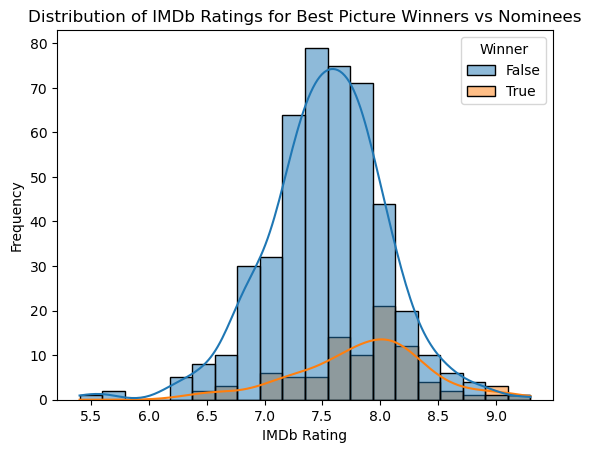

In [805]:
sns.histplot(data=movies_df, x='IMDbRating', hue='Winner', kde=True, bins=20)

plt.title('Distribution of IMDb Ratings for Best Picture Winners vs Nominees')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()

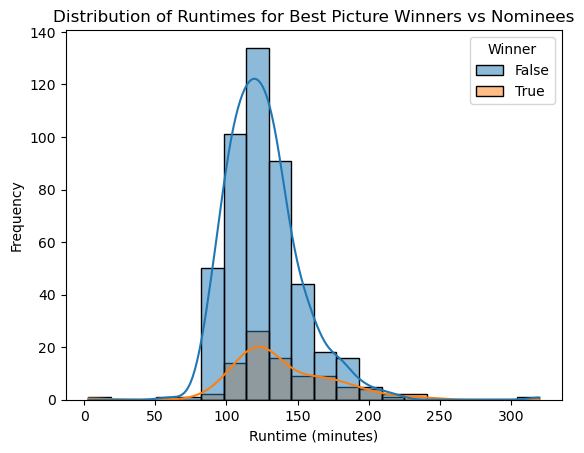

In [809]:
sns.histplot(data=movies_df, x='Runtime', hue='Winner', kde=True, bins=20)

plt.title('Distribution of Runtimes for Best Picture Winners vs Nominees')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()

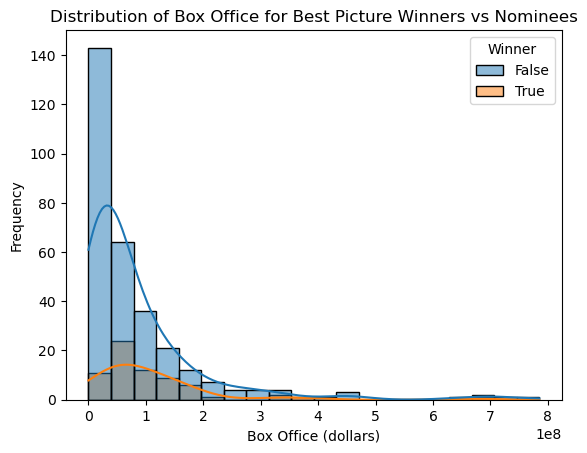

In [810]:
sns.histplot(data=movies_df, x='BoxOffice', hue='Winner', kde=True, bins=20)

plt.title('Distribution of Box Office for Best Picture Winners vs Nominees')
plt.xlabel('Box Office (dollars)')
plt.ylabel('Frequency')
plt.show()

In [811]:
# Split the 'director' column into individual directors if there are multiple directors listed in one cell
# (Assuming the 'director' column contains a list or comma-separated values)
#movies_df['Director'] = movies_df['Director'].apply(lambda x: x.split(',') if isinstance(x, str) else [x])

# Create a new DataFrame where each director is counted for each decade
# Exploding the 'director' column to have one director per row for counting
directors_expanded = movies_df.explode('Director')

# Group by 'decade' and 'director', then count occurrences
director_counts = directors_expanded.groupby(['Decade', 'Director']).size().reset_index(name='count')

# For each decade, get the most common director
most_common_directors = director_counts.loc[director_counts.groupby('Decade')['count'].idxmax()]

# Display the most common directors for each decade
print(most_common_directors)

     Decade              Director  count
79    1930s           Frank Capra      5
637   1940s                   nan      6
735   1950s        George Stevens      4
1237  1960s        Stanley Kramer      3
1352  1970s  Francis Ford Coppola      4
1881  1980s      Steven Spielberg      3
1994  1990s        Frank Darabont      2
2280  2000s        Clint Eastwood      3
2838  2010s      Steven Spielberg      4
2937  2020s      Denis Villeneuve      2


/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/3246212829.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  director_counts = directors_expanded.groupby(['Decade', 'Director']).size().reset_index(name='count')
/var/folders/8j/sxj04lqn4qg7hs60l9b18t300000gn/T/ipykernel_18007/3246212829.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_common_directors = director_counts.loc[director_counts.groupby('Decade')['count'].idxmax()]


In [818]:
winners_df = movies_df[movies_df['Winner'] == True]
non_winners_df = movies_df[movies_df['Winner'] == False]

In [822]:
# comparison of genres
def get_genre_counts(movies_df):
    # separate each genre into a row
    exploded_category = movies_df['Genre'].str.split(',').explode().str.strip()
    return exploded_category.value_counts()

# count winners vs non-winners
genre_counts_winners = get_genre_counts(winners_df)
genre_counts_non_winners = get_genre_counts(non_winners_df)

print("Genre Counts for Winners:")
print(genre_counts_winners)

print("\nGenre Counts for Non-Winners:")
print(genre_counts_non_winners)

Genre Counts for Winners:
Genre
Drama        82
Romance      22
Biography    20
Comedy       19
Crime        12
Adventure    10
War          10
History      10
Musical       7
Family        6
Thriller      6
Music         4
Mystery       3
Action        3
Sport         3
Film-Noir     2
nan           2
Western       2
Fantasy       2
Short         1
Name: count, dtype: int64

Genre Counts for Non-Winners:
Genre
Drama        410
Romance      135
Comedy       108
Biography     90
Crime         56
Adventure     56
History       50
Action        33
Thriller      31
Mystery       30
War           29
Music         26
Fantasy       26
Family        24
Musical       20
nan           20
Western       12
Sci-Fi        12
Film-Noir      9
Sport          7
Horror         4
Animation      3
Name: count, dtype: int64
